# Imports

In [ ]:
# necessary to use hugging-face
! pip install transformers

     |████████████████████████████████| 2.0MB 29.2MB/s 
     |████████████████████████████████| 3.2MB 51.5MB/s 
     |████████████████████████████████| 870kB 50.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=9355cf7cadd0d44592d54a2c9d855bc2f31dfbc1e8755e1808824b7f1bcd5a90
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [ ]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# necessary import
import os
import nltk
import time
import torch
import pickle
import sklearn
import numpy as np
import pandas as pd
import torch.nn as nn
import tensorflow as tf
from string import punctuation
from google.colab import drive
import torch.nn.functional as F
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from scipy.spatial.distance import cosine
from transformers import BertTokenizer, BertModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix

% matplotlib inline
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/nlp/shared-task' 

# the following location [file_path] must contain all the sub-task fields
os.listdir(file_path)

Mounted at /content/drive


['question-answering',
 'named-entity-recognition',
 'machine-translation',
 'relation-classification',
 'text-classification']

# Create a fixed `train` and `val` set
- In each of the sub-directory there are 10 papers
    - Keep the last two as val set
    - Use the rest as a part of train set
\newline
- `train_corpus` or `val_corpus` both are a list of tuples:  
    - sub-task
    - sub-folder
    - actual sentence
    - label (0/1)
    - sentence embedding

In [ ]:
# filter the text file with Stanza parser
stanza_filter = lambda x: False if x.find('Stanza') == -1 else True

In [ ]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')      # change to `cased` if required

# load pre-trained model
# the model returns all hidden-states
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True)     # change to `cased` if required

# put model in eval mode
model = model.eval()

In [ ]:
with open('/content/drive/MyDrive/nlp/train_uncased_trial_sci.pkl', 'wb') as f:
    pickle.dump(train_uncased_sci, f)

In [ ]:
# with open('/content/drive/MyDrive/nlp/train_uncased_trial.pkl', 'wb') as f:
#     pickle.dump(train_uncased, f)

# with open('/content/drive/MyDrive/nlp/val_uncased_trial.pkl', 'wb') as f:
#     pickle.dump(val_uncased, f)

with open('/content/drive/MyDrive/nlp/train_uncased_trial.pkl', 'rb') as f:
    train_uncased = pickle.load(f)

with open('/content/drive/MyDrive/nlp/val_uncased_trial.pkl', 'rb') as f:
    val_uncased = pickle.load(f)

# with open('/content/drive/MyDrive/nlp/train_uncased_trial_four_layer.pkl', 'wb') as f:
#     pickle.dump(train_uncased_four_layer, f)

# with open('/content/drive/MyDrive/nlp/train_hidden_states.pkl', 'wb') as f:
#     pickle.dump(hidden_states, f)

with open('/content/drive/MyDrive/nlp/train_uncased_trial_four_layer.pkl', 'rb') as f:
    train_uncased_four_layer = pickle.load(f)

with open('/content/drive/MyDrive/nlp/train_hidden_states.pkl', 'rb') as f:
    train_hidden_states = pickle.load(f)

print(len(train_uncased), len(val_uncased))

9049 2436


In [ ]:
with open('/content/drive/MyDrive/nlp/train_uncased_trial.pkl', 'rb') as f:
    train_uncased = pickle.load(f)

with open('/content/drive/MyDrive/nlp/val_uncased_trial.pkl', 'rb') as f:
    val_uncased = pickle.load(f)

In [ ]:
train_corpus = []   # training corpus
val_corpus = []     # val corpus
# iterate over each folder
for folder in os.listdir(file_path): # ['question-answering', 'named-entity-recognition', 'machine-translation', 'relation-classification', 'text-classification']:
    # iterate over 10 sub-folders 
    # 0 - 7 are added to training corpus
    # 8 - 9 are added to val corpus
    for sub_folder in os.listdir(os.path.join(('/content/drive/MyDrive/nlp/shared-task'), folder)):

        path = os.listdir(os.path.join(('/content/drive/MyDrive/nlp/shared-task'), folder, sub_folder))
        stanza_filtered = filter(stanza_filter, path)

        # obtain the indices of important senteces from sentences.txt
        with open('/content/drive/MyDrive/nlp/shared-task/' + folder + '/' + sub_folder + '/sentences.txt' ) as f:
            important_sentences = [x for x in f.readlines()]

        # create the corpus as a list of (<task-name>, <sub-folder 0-9>, <sentence>) tuples
        for stanza in stanza_filtered:
            with open('/content/drive/MyDrive/nlp/shared-task/' + folder + '/' + sub_folder + '/' + stanza ) as f:
                corpus =[(folder, sub_folder, x.strip('\n')) for x in f.readlines()]

        # create the labels for each sentence
        # contribution sentences are denoted 1
        # non-contribution sentences are denoted 0
        target = np.zeros(len(corpus))
        for number in important_sentences:
            target[int(number) - 1] = 1

        # create _corpus as a list of (<task-name>, <sub-folder 0-9>, <sentence>, <target>) tuples
        _corpus = []
        for (a, b, c), d in zip(corpus, target):
            _corpus.append((a,b,c,d))

        # if sub-folder is less than 8 add to training corpus
        # else add to val corpus
        if int(sub_folder) < 8:
            train_corpus.extend(_corpus)

        else:
            val_corpus.extend(_corpus)

In [ ]:
# uncased train set [convert it to train_cased in BERT-cased]
train_uncased = []

with tf.device('/device:GPU:0'):
    # iterate over train_corpus
    for tup in train_corpus:
        # modify the text to include the [CLS] and [SEP] tokens
        # tokenize the text
        # obtain the respective indices
        marked_text = "[CLS] " + tup[0] + " [SEP] " + tup[2]
        tokenized_text = tokenizer.tokenize(marked_text)
        indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

        # create the segment ids
        # every token till [SEP] including is marked 0
        # every other remaining token is marked 1 
        segments_ids = [0] * len(tokenized_text)
        j = 0
        while j < len(tokenized_text):
            if tokenized_text[j] == "[SEP]":
                break
            j+=1
        segments_ids[(j+1):] = [1] * len(segments_ids[(j+1):])

        # use torch.tensor() to obtain the token and segment tensors
        tokens_tensor = torch.tensor([indexed_tokens])
        segments_tensors = torch.tensor([segments_ids])

        # no need of computation graph
        with torch.no_grad():
            # obtain the outputs and hidden states
            outputs = model(tokens_tensor, segments_tensors)
            hidden_states = outputs[2]

        # sentence embedding as the embedding of [CLS] token
        # append the sentence embedding to the end of each tuple
        sentence_embedding = hidden_states[-1][0][0]
        train_uncased.append((tup[0], tup[1], tup[2], tup[3], sentence_embedding))

# display the length of training set
print(len(train_uncased), len(train_corpus))

In [ ]:
# uncased val set [convert it to val_cased in BERT-cased]
val_uncased = []

with tf.device('/device:GPU:0'):
    # iterate over val_corpus
    for tup in val_corpus:
        # modify the text to include the [CLS] and [SEP] tokens
        # tokenize the text
        # obtain the respective indices
        marked_text = "[CLS] " + tup[0] + " [SEP] " + tup[2]
        tokenized_text = tokenizer.tokenize(marked_text)
        indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

        # create the segment ids
        # every token till [SEP] including is marked 0
        # every other remaining token is marked 1 
        segments_ids = [0] * len(tokenized_text)
        j = 0
        while j < len(tokenized_text):
            if tokenized_text[j] == "[SEP]":
                break
            j+=1
        segments_ids[(j+1):] = [1] * len(segments_ids[(j+1):])

        # use torch.tensor() to obtain the token and segment tensors
        tokens_tensor = torch.tensor([indexed_tokens])
        segments_tensors = torch.tensor([segments_ids])

        # no need of computation graph
        with torch.no_grad():
            # obtain the outputs and hidden states
            outputs = model(tokens_tensor, segments_tensors)
            hidden_states = outputs[2]

        # sentence embedding as the embedding of [CLS] token
        # append the sentence embedding to the end of each tuple
        sentence_embedding = hidden_states[-1][0][0]
        val_uncased.append((tup[0], tup[1], tup[2], tup[3], sentence_embedding))

# display the length of training set
print(len(val_uncased), len(val_corpus))

2436 2436


In [ ]:
# uncased train set [convert it to train_cased in BERT-cased]
train_uncased_four_layer = []

with tf.device('/device:GPU:0'):
    # iterate over train_corpus
    for tup in train_corpus:
        # modify the text to include the [CLS] and [SEP] tokens
        # tokenize the text
        # obtain the respective indices
        marked_text = "[CLS] " + tup[0] + " [SEP] " + tup[2]
        tokenized_text = tokenizer.tokenize(marked_text)
        indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

        # create the segment ids
        # every token till [SEP] including is marked 0
        # every other remaining token is marked 1 
        segments_ids = [0] * len(tokenized_text)
        j = 0
        while j < len(tokenized_text):
            if tokenized_text[j] == "[SEP]":
                break
            j+=1
        segments_ids[(j+1):] = [1] * len(segments_ids[(j+1):])

        # use torch.tensor() to obtain the token and segment tensors
        tokens_tensor = torch.tensor([indexed_tokens])
        segments_tensors = torch.tensor([segments_ids])

        # no need of computation graph
        with torch.no_grad():
            # obtain the outputs and hidden states
            outputs = model(tokens_tensor, segments_tensors)
            hidden_states = outputs[2]

        # tokens_vecs as sum of last four layers
        token_vecs = hidden_states[-4][0] + hidden_states[-3][0] + hidden_states[-2][0] + hidden_states[-1][0]

        # sentence embedding as the average of sum of token embeddings in the last four layers
        # append the sentence embedding to the end of each tuple
        sentence_embedding = torch.mean(token_vecs, dim=0)
        train_uncased_four_layer.append((tup[0], tup[1], tup[2], tup[3], sentence_embedding))

# display the length of training set
print(len(train_uncased_four_layer), len(train_corpus))

9049 9049


In [ ]:
# all_corpus = []
# labels = []
# for folder in ['question-answering', 'named-entity-recognition', 'machine-translation', 'relation-classification', 'text-classification']:
#     for sub_folder in os.listdir(os.path.join(('/content/drive/MyDrive/nlp/shared-task'), folder)):
#         path = os.listdir(os.path.join(('/content/drive/MyDrive/nlp/shared-task'), folder, sub_folder))
#         stanza_filtered = filter(stanza_filter, path)
#         for stanza in stanza_filtered:
#             with open('/content/drive/MyDrive/nlp/shared-task/' + folder + '/' + sub_folder + '/' + stanza ) as f:
#                 corpus =[x.strip('\n') for x in f.readlines()]
        
#         with open('/content/drive/MyDrive/nlp/shared-task/' + folder + '/' + sub_folder + '/sentences.txt' ) as f:
#             important_sentences = [x for x in f.readlines()]

#         target = np.zeros(len(corpus))
#         for number in important_sentences:
#             target[int(number) - 1] = 1
        
#         all_corpus.extend(corpus)
#         labels.extend(target)

## For `sci-BERT` (using top 4 layers)

In [ ]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')      # change to `cased` if required

# load pre-trained model
# the model returns all hidden-states
model = BertModel.from_pretrained('allenai/scibert_scivocab_uncased', output_hidden_states = True)     # change to `cased` if required

# put model in eval mode
model = model.eval()

In [ ]:
train_corpus_sci = []   # training corpus
val_corpus_sci = []     # val corpus
# iterate over each folder
for folder in os.listdir(file_path): # ['question-answering', 'named-entity-recognition', 'machine-translation', 'relation-classification', 'text-classification']:
    # iterate over 10 sub-folders 
    # 0 - 7 are added to training corpus
    # 8 - 9 are added to val corpus
    for sub_folder in os.listdir(os.path.join(('/content/drive/MyDrive/nlp/shared-task'), folder)):

        path = os.listdir(os.path.join(('/content/drive/MyDrive/nlp/shared-task'), folder, sub_folder))
        stanza_filtered = filter(stanza_filter, path)

        # obtain the indices of important senteces from sentences.txt
        with open('/content/drive/MyDrive/nlp/shared-task/' + folder + '/' + sub_folder + '/sentences.txt' ) as f:
            important_sentences = [x for x in f.readlines()]

        # create the corpus as a list of (<task-name>, <sub-folder 0-9>, <sentence>) tuples
        for stanza in stanza_filtered:
            with open('/content/drive/MyDrive/nlp/shared-task/' + folder + '/' + sub_folder + '/' + stanza ) as f:
                corpus =[(folder, sub_folder, x.strip('\n')) for x in f.readlines()]

        # create the labels for each sentence
        # contribution sentences are denoted 1
        # non-contribution sentences are denoted 0
        target = np.zeros(len(corpus))
        for number in important_sentences:
            target[int(number) - 1] = 1

        # create _corpus as a list of (<task-name>, <sub-folder 0-9>, <sentence>, <target>) tuples
        _corpus = []
        for (a, b, c), d in zip(corpus, target):
            _corpus.append((a,b,c,d))

        # if sub-folder is less than 8 add to training corpus
        # else add to val corpus
        if int(sub_folder) < 8:
            train_corpus_sci.extend(_corpus)

        else:
            val_corpus_sci.extend(_corpus)

In [ ]:
# uncased train set [convert it to train_cased in BERT-cased]
train_uncased_sci = []

with tf.device('/device:GPU:0'):
    # iterate over train_corpus
    for tup in train_corpus_sci:
        # modify the text to include the [CLS] and [SEP] tokens
        # tokenize the text
        # obtain the respective indices
        marked_text = "[CLS] " + tup[0] + " [SEP] " + tup[2]
        tokenized_text = tokenizer.tokenize(marked_text)
        indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

        # create the segment ids
        # every token till [SEP] including is marked 0
        # every other remaining token is marked 1 
        segments_ids = [0] * len(tokenized_text)
        j = 0
        while j < len(tokenized_text):
            if tokenized_text[j] == "[SEP]":
                break
            j+=1
        segments_ids[(j+1):] = [1] * len(segments_ids[(j+1):])

        # use torch.tensor() to obtain the token and segment tensors
        tokens_tensor = torch.tensor([indexed_tokens])
        segments_tensors = torch.tensor([segments_ids])

        # no need of computation graph
        with torch.no_grad():
            # obtain the outputs and hidden states
            outputs = model(tokens_tensor, segments_tensors)
            hidden_states = outputs[2]

        # tokens_vecs as sum of last four layers
        token_vecs = hidden_states[-4][0] + hidden_states[-3][0] + hidden_states[-2][0] + hidden_states[-1][0]

        # sentence embedding as the average of sum of token embeddings in the last four layers
        # append the sentence embedding to the end of each tuple
        sentence_embedding = torch.mean(token_vecs, dim=0)
        train_uncased_sci.append((tup[0], tup[1], tup[2], tup[3], sentence_embedding))

# display the length of training set
print(len(train_uncased_sci), len(train_corpus_sci))

9049 9049


# TF-IDF Baseline Approach

---
- very poor for class label 1
- but captures the idea of label 0 very well
- high accuracy just because the label 0 is extremely dominant compared to label 1


In [ ]:
# obtain the lemmatizer and add some stop-words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')).union({'man', 'woman', 'west', 'south', 'north', 'east'})

# define a tokenizer and use it in TfidfVectorizer
def tokenizer(document):
    # ensure the tokens are in lemmatized, have a length of at least two, are only alphabetic, and not a stop_word
    words = [lemmatizer.lemmatize(words) for words in document.split() if len(words) > 2 and words.isalpha() and not words in stop_words]
    
    # make a mapping of replacing punctuation
    # use to replace punctuation in the words
    table = str.maketrans('', '', punctuation)
    words = [word.translate(table) for word in words]
    
    # return the words (contains the tokens)
    return words

# prepare the TfidfVectorizer
# we capture the best 1000 features
tfidf = TfidfVectorizer(ngram_range=(1,2), 
                        max_df=20, 
                        min_df=5, 
                        max_features=800,
                        tokenizer=tokenizer)

# tfidf for question-answering [can be easily replaced with other sub-tasks]
# remove the if condition in list comprehension if a single tf-idf is needed for all sub-tasks
with tf.device('/GPU:0'):
    corpus = [x[2] for x in train_corpus if x[0] == 'question-answering']
    tfidf = tfidf.fit(corpus)
    data = tfidf.transform(corpus).toarray() 
labels = [x[3] for x in train_corpus if x[0] == 'question-answering']

Accuracy on training data: 0.9305039787798408
Accuracy on test data: 0.9333333333333333
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.97       196
         1.0       0.00      0.00      0.00        14

    accuracy                           0.93       210
   macro avg       0.47      0.50      0.48       210
weighted avg       0.87      0.93      0.90       210

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96      1749
         1.0       1.00      0.04      0.07       136

    accuracy                           0.93      1885
   macro avg       0.97      0.52      0.52      1885
weighted avg       0.94      0.93      0.90      1885



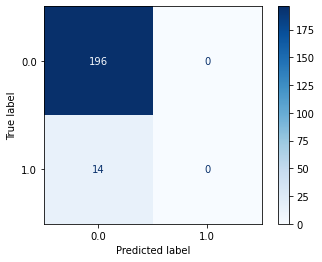

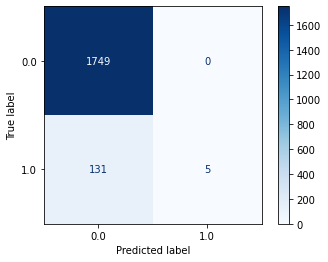

In [ ]:
# train_test_split 
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.1)

# classifier designing
clf = LogisticRegression(solver='newton-cg')
clf = clf.fit(data_train, labels_train)

# display accuracies
print(f'Accuracy on training data: {clf.score(data_train, labels_train)}')
print(f'Accuracy on test data: {clf.score(data_test, labels_test)}')

# display confusion matrices
plot_confusion_matrix(clf, data_test, labels_test, values_format='d', cmap='Blues');
plot_confusion_matrix(clf, data_train, labels_train, values_format='d', cmap='Blues');

# display classification reports
print(classification_report(labels_test, clf.predict(data_test)))
print(classification_report(labels_train, clf.predict(data_train)))

# BERT (without any fine-tuning)
---

`The major problem is the BERT input size should be less than 512`

 ## `Approach 1`: Use `[CLS]` token as sentence representation
 - Not much difference between cased and uncased BERT
 

### BERT-uncased

In [ ]:
# obtain the list of tensors corresponding to train data and labels
x = [tup[-1] for tup in train_uncased]
y = [tup[-2] for tup in train_uncased]

# create a torch tensor from the above list
X = torch.zeros((len(x), len(x[0])))
Y = torch.zeros((len(y), 1))
for i in range(len(x)):
    X[i] = x[i]
    Y[i] = y[i]

In [ ]:
# define a Neural Network class
class NeuralNetwork(torch.nn.Module):
    def __init__(self, num_features, num_classes=1):
        super(NeuralNetwork, self).__init__()

        self.num_features = num_features
        self.num_classes = num_classes

        self.fc1 = nn.Linear(self.num_features, 1024)  
        self.fc2 = nn.Linear(1024, 32)
        self.fc3 = nn.Linear(32, self.num_classes)

    # forward functions
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

# define important variables in context of neural network training
num_features = 768
num_classes = 1
batch_size = 64
learning_rate = 0.0001

# create Model
model = NeuralNetwork(num_features, num_classes)

# optimizer - loss - epochs
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
my_loss = nn.BCELoss()
epochs = 100

In [ ]:
# perform a train test split for training
tensor_x_train, tensor_x_test, tensor_y_train, tensor_y_test = train_test_split(X, Y, test_size = 0.1, random_state = 13)

# create TensorDataset and DataLoader for train and test
train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
train_data = DataLoader(train_dataset, batch_size)
test_data = DataLoader(test_dataset)

In [ ]:
# trianing loop
for i in range(epochs):
    for xb, yb in train_data:
        output = model.forward(xb) 
        loss = my_loss(output, yb)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(i+1, epochs, loss.item()))

In [ ]:
# put model into eval mode
model = model.eval()
y_pred, y_true = [], []

# obtain the true and pred labels
for tx, ty in test_data:
    with torch.no_grad():
        output = model.forward(tx)
        output = np.array((output == 1).detach(), dtype=np.float32)
        y_pred.extend(output)
        y_true.extend(np.array(ty))
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# report accuracy - classification report - confusion matrix on test set
print(f'Accuracy on testing data: {sklearn.metrics.accuracy_score(y_true, y_pred)}')
print(classification_report(y_true, y_pred))
print(sklearn.metrics.confusion_matrix(y_true, y_pred))

Accuracy on training data: 0.9193370165745857
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       831
         1.0       1.00      0.01      0.03        74

    accuracy                           0.92       905
   macro avg       0.96      0.51      0.49       905
weighted avg       0.93      0.92      0.88       905

[[831   0]
 [ 73   1]]


### BERT-cased

In [ ]:
# obtain the list of tensors corresponding to train data and labels
x = [tup[-1] for tup in train_cased]
y = [tup[-2] for tup in train_cased]

# create a torch tensor from the above list
X = torch.zeros((len(x), len(x[0])))
Y = torch.zeros((len(y), 1))
for i in range(len(x)):
    X[i] = x[i]
    Y[i] = y[i]

In [ ]:
# define a Neural Network class
class NeuralNetwork(torch.nn.Module):
    def __init__(self, num_features, num_classes=1):
        super(NeuralNetwork, self).__init__()

        self.num_features = num_features
        self.num_classes = num_classes

        self.fc1 = nn.Linear(self.num_features, 1024)  
        self.fc2 = nn.Linear(1024, 32)
        self.fc3 = nn.Linear(32, self.num_classes)

    # forward functions
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

# define important variables in context of neural network training
num_features = 768
num_classes = 1
batch_size = 64
learning_rate = 0.0001

# create Model
model = NeuralNetwork(num_features, num_classes)

# optimizer - loss - epochs
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
my_loss = nn.BCELoss()
epochs = 100

In [ ]:
# perform a train test split for training
tensor_x_train, tensor_x_test, tensor_y_train, tensor_y_test = train_test_split(X, Y, test_size = 0.1, random_state = 13)

# create TensorDataset and DataLoader for train and test
train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
train_data = DataLoader(train_dataset, batch_size)
test_data = DataLoader(test_dataset)

In [ ]:
# trianing loop
for i in range(epochs):
    for xb, yb in train_data:
        output = model.forward(xb) 
        loss = my_loss(output, yb)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(i+1, epochs, loss.item()))

In [ ]:
# put model into eval mode
model = model.eval()
y_pred, y_true = [], []

# obtain the true and pred labels
for tx, ty in test_data:
    with torch.no_grad():
        output = model.forward(tx)
        output = np.array((output == 1).detach(), dtype=np.float32)
        y_pred.extend(output)
        y_true.extend(np.array(ty))
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# report accuracy - classification report - confusion matrix on test set
print(f'Accuracy on testing data: {sklearn.metrics.accuracy_score(y_true, y_pred)}')
print(classification_report(y_true, y_pred))
print(sklearn.metrics.confusion_matrix(y_true, y_pred))

Accuracy on training data: 0.918232044198895
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       831
         1.0       0.00      0.00      0.00        74

    accuracy                           0.92       905
   macro avg       0.46      0.50      0.48       905
weighted avg       0.84      0.92      0.88       905

[[831   0]
 [ 74   0]]


## `Approach 2:` Use average of all constituent tokens as sentence representation

In [ ]:
# obtain the list of tensors corresponding to train data and labels
x = [tup[-1] for tup in train_uncased_sci]
y = [tup[-2] for tup in train_uncased_sci]

# create a torch tensor from the above list
X = torch.zeros((len(x), len(x[0])))
Y = torch.zeros((len(y), 1))
for i in range(len(x)):
    X[i] = x[i]
    Y[i] = y[i]

In [ ]:
# define a Neural Network class
class NeuralNetwork(torch.nn.Module):
    def __init__(self, num_features, num_classes=1):
        super(NeuralNetwork, self).__init__()

        self.num_features = num_features
        self.num_classes = num_classes

        self.fc1 = nn.Linear(self.num_features, 512)  
        self.fc2 = nn.Linear(512, 32)
        self.fc3 = nn.Linear(32, self.num_classes)

    # forward functions
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

# define important variables in context of neural network training
num_features = 768
num_classes = 1
batch_size = 64
learning_rate = 0.0001

# create Model
model = NeuralNetwork(num_features, num_classes)

# optimizer - loss - epochs
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
my_loss = nn.BCELoss()
epochs = 100

In [ ]:
# perform a train test split for training
tensor_x_train, tensor_x_test, tensor_y_train, tensor_y_test = train_test_split(X, Y, test_size = 0.1, random_state = 0)

# create TensorDataset and DataLoader for train and test
train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
train_data = DataLoader(train_dataset, batch_size)
test_data = DataLoader(test_dataset)

In [ ]:
epochs = 30
# trianing loop
for i in range(epochs):
    for xb, yb in train_data:
        if np.random.randn() > 0.5:
            print(yb)
            optimizer.zero_grad()
            output = model.forward(xb) 
            loss = my_loss(output, yb)
            loss.backward()
            optimizer.step()
            
    print('Epoch [{}/{}], Loss: {:.4f}'.format(i+1, epochs, loss.item()))

In [ ]:
# put model into eval mode
model = model.eval()
y_pred, y_true = [], []

# obtain the true and pred labels
for tx, ty in test_data:
    with torch.no_grad():
        output = model.forward(tx)
        output = np.array((output == 1).detach(), dtype=np.float32)
        y_pred.extend(output)
        y_true.extend(np.array(ty))
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# report accuracy - classification report - confusion matrix on test set
print(f'Accuracy on testing data: {sklearn.metrics.accuracy_score(y_true, y_pred)}')
print(classification_report(y_true, y_pred))
print(sklearn.metrics.confusion_matrix(y_true, y_pred))

Accuracy on testing data: 0.9005524861878453
              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95       815
         1.0       0.00      0.00      0.00        90

    accuracy                           0.90       905
   macro avg       0.45      0.50      0.47       905
weighted avg       0.81      0.90      0.85       905

[[815   0]
 [ 90   0]]


In [ ]:
# utilising a logistic regression to see performance
clf = LogisticRegression()
clf = clf.fit(tensor_x_train, tensor_y_train)

# report accuracy - classification report - confusion matrix on test set
y_pred = clf.predict(tensor_x_test)
print(f'Accuracy on testing data: {sklearn.metrics.accuracy_score(tensor_y_test, y_pred)}')
print(classification_report(tensor_y_test, y_pred))
print(sklearn.metrics.confusion_matrix(tensor_y_test, y_pred))

Accuracy on testing data: 0.881767955801105
              precision    recall  f1-score   support

         0.0       0.91      0.96      0.94       815
         1.0       0.30      0.14      0.20        90

    accuracy                           0.88       905
   macro avg       0.61      0.55      0.57       905
weighted avg       0.85      0.88      0.86       905

[[785  30]
 [ 77  13]]


## `Approach 3:`
---
`use of document vector`
--
- Obtain all the sentence embeddings  
    - Use the method which provides better result in the `Approach 1` and `Approach 2`
- Average them to obtain the documents embedding: `document vector`  
    - `document vector` can also be obtained by other way(s):
        - Perform topic modeling: do a linear combination of topics to obtain the `document vector`
- Use `document vector`:
    - Find cosine similarity between the `document vector` and `sentence vectors`.   
    Decide a threshold which provides better classification report  
    - Train a NN classifier to take input as `<sentence vector, document vector>` and output a binary class `0 or 1`


### Create dictionary for `document vectors` 
- use of `find_document_vector` method
- key: `task_name`  
    - key: `article_id`  
        - value: `document vector`

In [ ]:
# function to find the document vector 
def find_document_vector(task_name, article_id, data):

    # obtain all the vectors relevant 
    # conditioned on input task_name and article_id
    document = []
    for tup in data:
        if tup[0] == task_name and tup[1] == article_id:
            document.append(tup[4])
        else:
            continue

    # convert list of all relevant document vectors to torch tensor
    _vec = torch.zeros((len(document), 768))
    for i in range(len(document)):
        _vec[i] = document[i]

    # obtain the mean of all relevant document vectors
    doc_vec = torch.mean(_vec, keepdim=False, dim = 0)
    return doc_vec

In [ ]:
# create the doc_vec_dict
# key: task_name
#   key: article_id
#       value: document vector obtained from find_document_vector() method

doc_vec_dict = {}
for task_name in os.listdir(file_path):
    doc_vec_dict[task_name] = {}
    for article_id in os.listdir(file_path + '/' + task_name):
        doc_vec = find_document_vector(task_name, article_id, train_uncased_sci)
        doc_vec_dict[task_name][article_id] = doc_vec

# save the doc_vec_dict with pickle
with open('/content/drive/MyDrive/nlp/doc_vec_dict_sci.pkl', 'wb') as f:
    pickle.dump(doc_vec_dict, f)

### Model training with the addition of `document vectors`

In [ ]:
X = torch.zeros((len(train_uncased_sci), 1536))
Y = torch.zeros((len(train_uncased_sci), 1))

# obtain concatenated input vectors to be trained in a NN
# concatenate document vector and sentence embedding
idx = 0
for tup in train_uncased_sci:
    sub_task = tup[0]
    article_id = tup[1]
    sentence = tup[4]
    doc_vec = doc_vec_dict[sub_task][article_id]

    # Calculate the cosine similarity between the doc_vec and sentence 
    print(f'Label: {tup[3]} & Similarity: {1 - cosine(doc_vec, sentence)}')

    X[idx] = torch.cat((doc_vec, sentence))
    Y[idx] = tup[3]

    idx += 1
    if idx > 1000:
        break

Label: 0.0 & Similarity: 0.47892239689826965
Label: 1.0 & Similarity: 0.8308533430099487
Label: 0.0 & Similarity: 0.6068963408470154
Label: 1.0 & Similarity: 0.8916981220245361
Label: 0.0 & Similarity: 0.9378146529197693
Label: 0.0 & Similarity: 0.9304652214050293
Label: 0.0 & Similarity: 0.904852569103241
Label: 0.0 & Similarity: 0.9253122210502625
Label: 0.0 & Similarity: 0.49557310342788696
Label: 0.0 & Similarity: 0.8977132439613342
Label: 0.0 & Similarity: 0.8664794564247131
Label: 0.0 & Similarity: 0.7181522250175476
Label: 0.0 & Similarity: 0.8192562460899353
Label: 0.0 & Similarity: 0.8638187050819397
Label: 0.0 & Similarity: 0.8984969854354858
Label: 0.0 & Similarity: 0.9108687043190002
Label: 0.0 & Similarity: 0.901175320148468
Label: 0.0 & Similarity: 0.9091981053352356
Label: 0.0 & Similarity: 0.8815624117851257
Label: 0.0 & Similarity: 0.8880872130393982
Label: 0.0 & Similarity: 0.9379107356071472
Label: 0.0 & Similarity: 0.9027085304260254
Label: 0.0 & Similarity: 0.92235

In [ ]:
# define a Neural Network class
class NeuralNetwork(torch.nn.Module):
    def __init__(self, num_features, num_classes=1):
        super(NeuralNetwork, self).__init__()

        self.num_features = num_features
        self.num_classes = num_classes

        self.fc1 = nn.Linear(self.num_features, 1024)  
        self.fc2 = nn.Linear(1024, 32)
        self.fc3 = nn.Linear(32, self.num_classes)

    # forward functions
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

# define important variables in context of neural network training
num_features = 1536
num_classes = 1
batch_size = 64
learning_rate = 0.0001

# create Model
model = NeuralNetwork(num_features, num_classes)

# optimizer - loss - epochs
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
my_loss = nn.BCELoss()
epochs = 100

In [ ]:
# perform a train test split for training
tensor_x_train, tensor_x_test, tensor_y_train, tensor_y_test = train_test_split(X, Y, test_size = 0.1, random_state = 13)

# create TensorDataset and DataLoader for train and test
train_dataset = TensorDataset(tensor_x_train, tensor_y_train)
test_dataset = TensorDataset(tensor_x_test, tensor_y_test)
train_data = DataLoader(train_dataset, batch_size)
test_data = DataLoader(test_dataset)

In [ ]:
epochs = 20
# trianing loop
for i in range(epochs):
    for xb, yb in train_data:
        if np.random.randn() > 0.5:
            output = model.forward(xb) 
            loss = my_loss(output, yb)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(i+1, epochs, loss.item()))

Epoch [1/20], Loss: 0.3095
Epoch [2/20], Loss: 0.3459
Epoch [3/20], Loss: 0.1925
Epoch [4/20], Loss: 0.3383
Epoch [5/20], Loss: 0.2272
Epoch [6/20], Loss: 0.1308
Epoch [7/20], Loss: 0.2249
Epoch [8/20], Loss: 0.1556
Epoch [9/20], Loss: 0.2240
Epoch [10/20], Loss: 0.3225
Epoch [11/20], Loss: 0.1061
Epoch [12/20], Loss: 0.1115
Epoch [13/20], Loss: 0.2236
Epoch [14/20], Loss: 0.1059
Epoch [15/20], Loss: 0.2303
Epoch [16/20], Loss: 0.2370
Epoch [17/20], Loss: 0.1134
Epoch [18/20], Loss: 0.2090
Epoch [19/20], Loss: 0.2191
Epoch [20/20], Loss: 0.1532


In [ ]:
# put model into eval mode
model = model.eval()
y_pred, y_true = [], []

# obtain the true and pred labels
for tx, ty in test_data:
    with torch.no_grad():
        output = model.forward(tx)
        output = np.array((output == 1).detach(), dtype=np.float32)
        y_pred.extend(output)
        y_true.extend(np.array(ty))
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# report accuracy - classification report - confusion matrix on test set
print(f'Accuracy on testing data: {sklearn.metrics.accuracy_score(y_true, y_pred)}')
print(classification_report(y_true, y_pred))
print(sklearn.metrics.confusion_matrix(y_true, y_pred))

Accuracy on testing data: 0.918232044198895
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       831
         1.0       0.00      0.00      0.00        74

    accuracy                           0.92       905
   macro avg       0.46      0.50      0.48       905
weighted avg       0.84      0.92      0.88       905

[[831   0]
 [ 74   0]]


In [ ]:
# utilising a logistic regression to see performance
clf = LogisticRegression()
clf = clf.fit(tensor_x_train, tensor_y_train)

# report accuracy - classification report - confusion matrix on test set
y_pred = clf.predict(tensor_x_test)
print(f'Accuracy on testing data: {sklearn.metrics.accuracy_score(tensor_y_test, y_pred)}')
print(classification_report(tensor_y_test, y_pred))
print(sklearn.metrics.confusion_matrix(tensor_y_test, y_pred))

Accuracy on testing data: 0.9160220994475138
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96       831
         1.0       0.43      0.08      0.14        74

    accuracy                           0.92       905
   macro avg       0.68      0.54      0.55       905
weighted avg       0.88      0.92      0.89       905

[[823   8]
 [ 68   6]]


# Other

In [ ]:
from time import sleep
while(1):
    sleep(360)
    print(1)

KeyboardInterrupt: ignored

In [ ]:
len(hidden_states)

13